In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from scipy import stats

In [2]:
font = {'size': 16}
plt.rc('font', **font)

In [3]:
def detect_drip(data, min_window=6, max_window=48, threshold=-0.03, increase_threshold=0.02):
  drips = []
  for i in range(len(data) - min_window):
    # ข้าม drip ก่อนหน้า
    if drips and i < drips[-1]['end_index']:
      continue
    
    close_price = data['close'].iloc[i]
    low_price = data['low'].iloc[i:i+min_window].min()
    drip_pct = (low_price - close_price) / close_price
    
    # ตรวจสอบเงื่อนไขการลดลงมากกว่า 3%
    if drip_pct <= threshold:
      end_index = i + min_window - 1
      duration = end_index - i + 1
      
      for j in range(i, i+max_window):
        high = data['high'].iloc[j]
        low = data['low'].iloc[j]
        open_price = data['open'].iloc[j]
        close = data['close'].iloc[j]
        
        # คำนวณ high-to-low % และตรวจสอบว่า open-to-close เป็นบวก
        high_to_low_pct = (high - low) / low
        if (close > open_price) and (high_to_low_pct > increase_threshold):
          end_index = j
          duration = end_index - i + 1
          drip_pct = (low_price - close_price) / close_price
          break
      
      if duration >= min_window and duration <= max_window:
        drips.append({
          'start_time': data.index[i],
          'close_price': close_price,
          'low_price': low_price,
          'drip_pct': drip_pct * 100,  # แปลงเป็น %
          'end_index': end_index,
          'duration': duration
        })
        
  
  return pd.DataFrame(drips)

In [4]:
data = pd.read_pickle(os.path.abspath("../datasets/processed/1h/BTCUSDT.pkl"))
data = data["2021-01-01":]

Summary of Drip Sizes:
Number of Drips: 464.00
Mean Drip Size (%): -3.91
Std Drip Size (%): 1.11
Min Drip Size (%): -9.92
Max Drip Size (%): -3.00
Median Drip Size (%): -3.48
Mean Duration (hours): 12.97
Std Duration (hours): 10.10
Min Duration (hours): 6.00
Max Duration (hours): 48.00
Median Duration (hours): 8.00


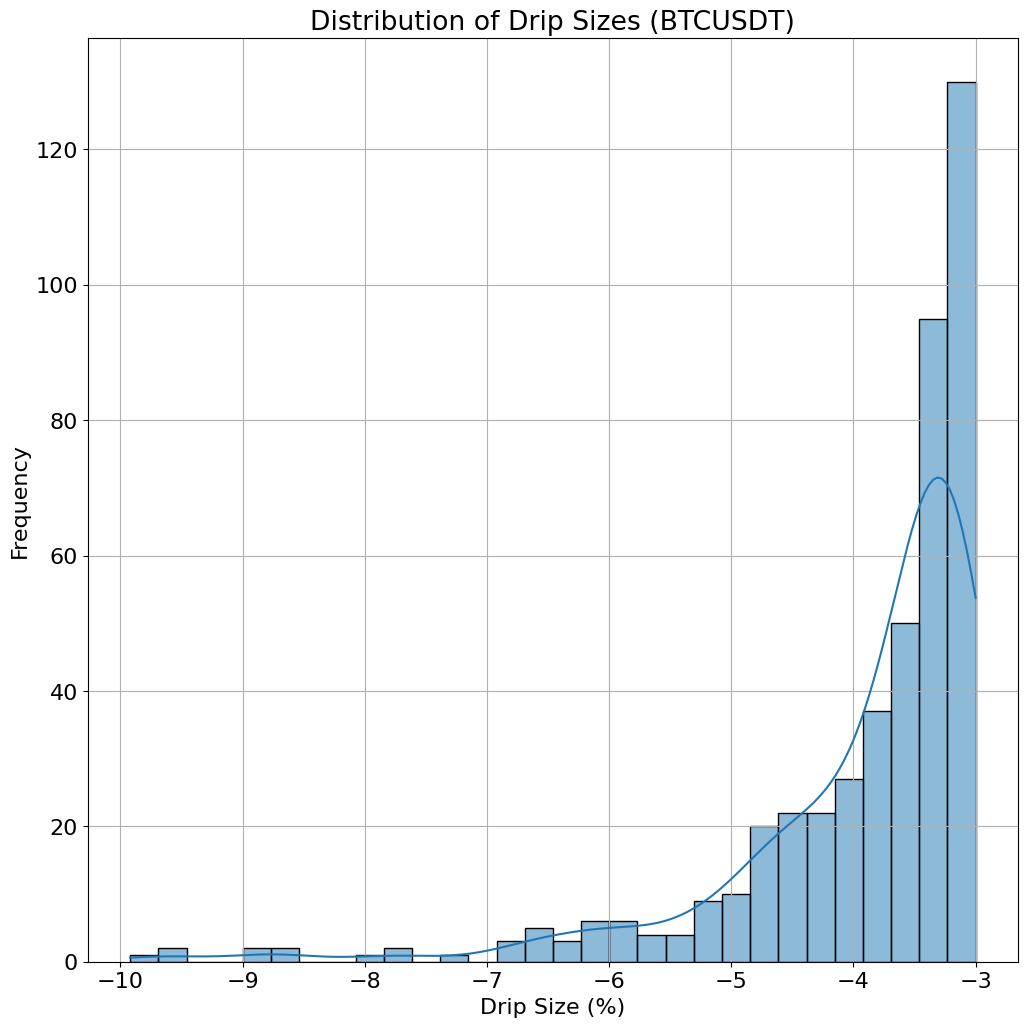

Shapiro-Wilk Test for Normality: stat=0.7276, p-value=0.0000
The distribution is not normal (p < 0.05)


In [5]:
drips = detect_drip(data, min_window=6, max_window=48, threshold=-0.03, increase_threshold=0.02)

# สรุปสถิติของขนาด Drip
drip_summary = {
    'Number of Drips': len(drips),
    'Mean Drip Size (%)': drips['drip_pct'].mean(),
    'Std Drip Size (%)': drips['drip_pct'].std(),
    'Min Drip Size (%)': drips['drip_pct'].min(),
    'Max Drip Size (%)': drips['drip_pct'].max(),
    'Median Drip Size (%)': drips['drip_pct'].median(),
    'Mean Duration (hours)': drips['duration'].mean(),
    'Std Duration (hours)': drips['duration'].std(),
    'Min Duration (hours)': drips['duration'].min(),
    'Max Duration (hours)': drips['duration'].max(),
    'Median Duration (hours)': drips['duration'].median()
}

print("Summary of Drip Sizes:")
for key, value in drip_summary.items():
    print(f"{key}: {value:.2f}")

# สร้างฮิสโตแกรมของขนาด Drip
plt.figure(figsize=(12, 12))
sns.histplot(drips['drip_pct'], bins=30, kde=True)
plt.title('Distribution of Drip Sizes (BTCUSDT)')
plt.xlabel('Drip Size (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# ทดสอบความปกติของการแจกแจง (Shapiro-Wilk Test)
stat, p_value = stats.shapiro(drips['drip_pct'])
print(f"Shapiro-Wilk Test for Normality: stat={stat:.4f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("The distribution is not normal (p < 0.05)")
else:
    print("The distribution is normal (p >= 0.05)")

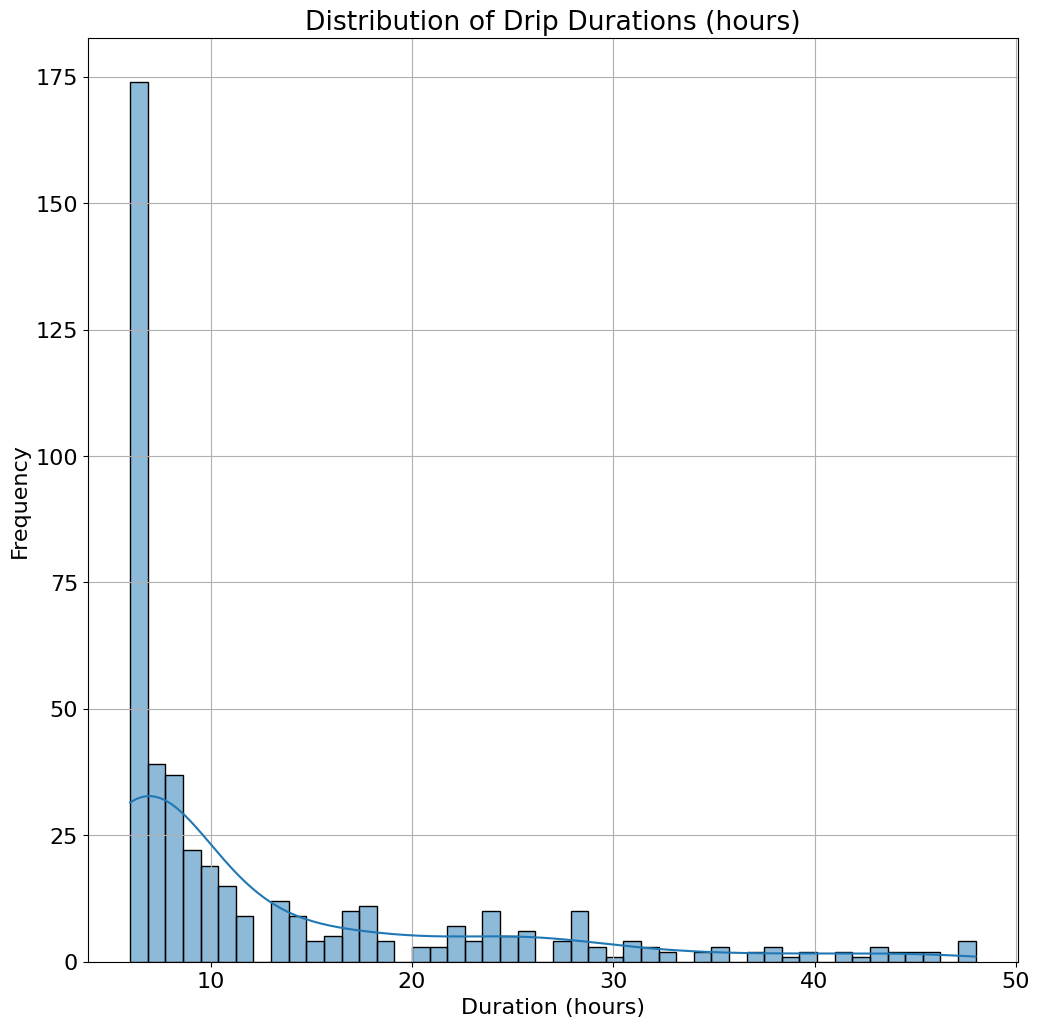

In [6]:
plt.figure(figsize=(12, 12))
sns.histplot(drips['duration'], bins=48, kde=True)
plt.title('Distribution of Drip Durations (hours)')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

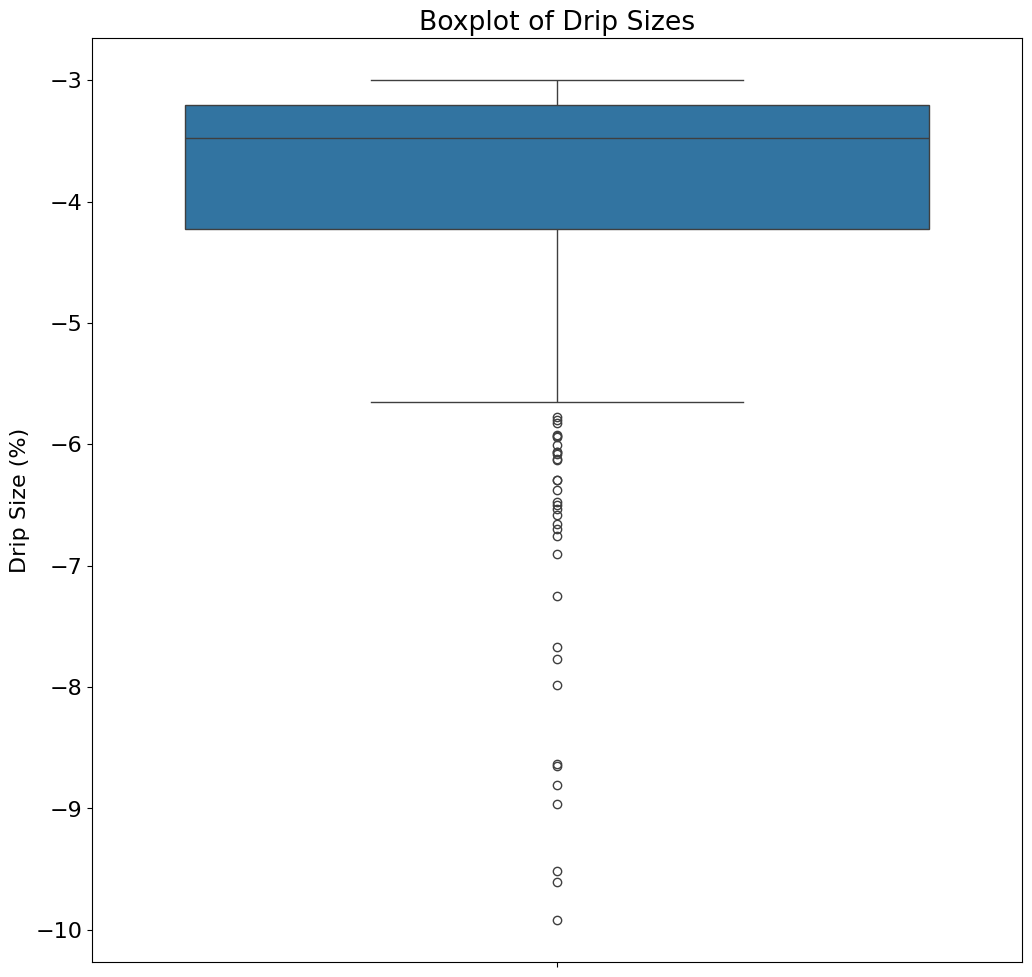

In [7]:
plt.figure(figsize=(12, 12))
sns.boxplot(y=drips['drip_pct'])
plt.title('Boxplot of Drip Sizes')
plt.ylabel('Drip Size (%)')
plt.show()

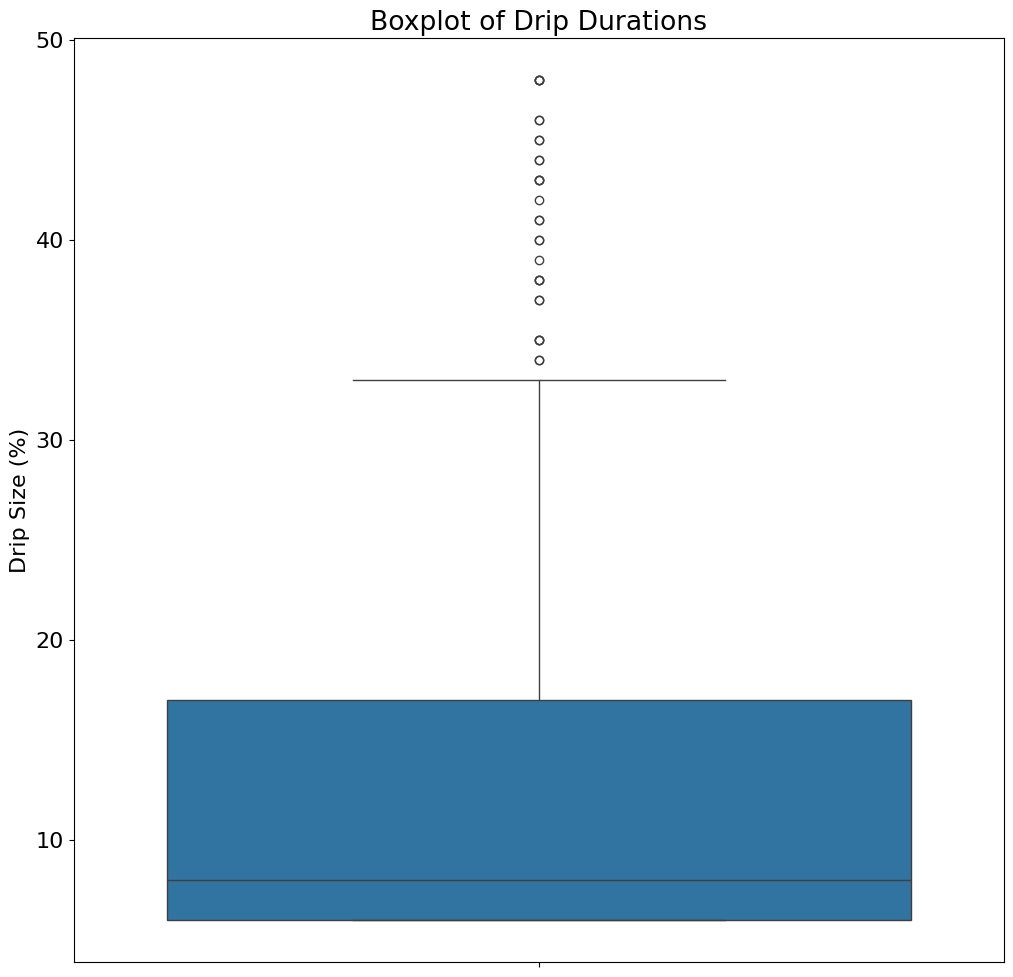

In [8]:
plt.figure(figsize=(12, 12))
sns.boxplot(y=drips['duration'])
plt.title('Boxplot of Drip Durations')
plt.ylabel('Drip Size (%)')
plt.show()